# Solar Forecast with LSTM
# Part 3: Model Data

In [1]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.metrics import classification_report

In [2]:
working_dir = '/Users/rick/Desktop/Argonne_Summer_Work/WeatherNet/Weather_LSTM'

## Make train generator

In [3]:
train_df = pd.read_csv(working_dir+"/train_weather.csv")
train_df.index = train_df['Unnamed: 0'].values
train_df.drop(['Unnamed: 0'],axis=1,inplace=True)
print(train_df.shape)
train_df.head()

(2157, 310)


,Average 60 m wind direction (scalar) (units: deg),Average 60 m wind speed (scalar) (units: m/s),Standard deviation of 60 m wind direction (units: deg),Average 60 m temperature (units:deg C),Average 10 m wind direction (scalar) (units: deg),Average 10 m wind speed (scalar) (units: m/s),Standard deviation of 10 m wind direction (units: deg),Average 10 m temperature (units: deg C),Average dew point temperature (units: deg C),Average relative humidity (units: %),...,t9_2.0,t10_0.0,t10_1.0,t10_2.0,t11_0.0,t11_1.0,t11_2.0,t12_0.0,t12_1.0,t12_2.0
2020_01_01_12,0.205770,0.767677,0.233988,0.306061,0.002057,0.000060,0.500063,0.477164,0.070776,0.075093,...,0,1,0,0,1,0,0,1,0,0
2020_01_01_13,0.204268,0.797980,0.233134,0.339394,0.002054,0.000060,0.500068,0.502159,0.084475,0.075736,...,0,1,0,0,1,0,0,1,0,0
2020_01_01_14,0.190142,0.797980,0.238258,0.366667,0.001921,0.000060,0.500063,0.520336,0.099315,0.079722,...,0,1,0,0,1,0,0,1,0,0
2020_01_01_15,0.188539,0.828283,0.232280,0.375758,0.001905,0.000058,0.500061,0.522608,0.107306,0.082551,...,0,1,0,0,1,0,0,1,0,0
2020_01_01_16,0.185935,0.797980,0.237404,0.354545,0.001907,0.000053,0.500064,0.502159,0.116438,0.092966,...,0,1,0,0,1,0,0,1,0,0


In [4]:
train_df['p_target'].head(15)

2020_01_01_12    2
2020_01_01_13    2
2020_01_01_14    2
2020_01_01_15    1
2020_01_01_16    0
2020_01_01_17    0
2020_01_01_18    0
2020_01_01_19    0
2020_01_01_20    0
2020_01_01_21    0
2020_01_01_22    0
2020_01_01_23    2
2020_01_01_24    0
2020_01_02_00    0
2020_01_02_01    0
Name: p_target, dtype: int64

In [5]:
y_train = train_df["p_target"].values
y_train_hot = np.zeros((y_train.size, y_train.max()+1))
y_train_hot[np.arange(y_train.size),y_train] = 1

train_df.drop(['p_target'],axis=1,inplace=True)
X_train = train_df.values
print(X_train.shape)

(2157, 309)


In [6]:
time_steps = 1
train_gen = TimeseriesGenerator(X_train, y_train_hot,length=time_steps, batch_size=16)
print(len(train_gen))

135


In [7]:
# test generator to have corresponding labels
batch_0 = train_gen[0]
x, y = batch_0

print(x.shape)
print(y)

(16, 1, 309)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


## Declare Model

In [8]:
class T2V(Layer):
    
    def __init__(self, output_dim=None, input_dim=None, **kwargs):
        self.output_dim = output_dim
        self.input_dim = input_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(self.output_dim, self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.B = self.add_weight(name='B',
                                shape=(self.input_dim, self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(1, 1),
                                initializer='uniform',
                                trainable=True)

        self.b = self.add_weight(name='b',
                                shape=(self.input_dim, 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, time,p):
        original = self.w * p + self.b
        x = K.repeat_elements(time, self.output_dim, -1)
        sin_trans = K.sin(K.dot(x, self.W) + self.B)
        return K.concatenate([sin_trans,original], -1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.output_dim+1)

In [9]:
i = Input(shape=(time_steps,X_train.shape[1]))

x = LSTM(32,kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4),\
    bias_regularizer=regularizers.l2(1e-4),\
        recurrent_dropout=0.15,dropout=.15,return_sequences=False)(i)
x = Dropout(.2)(x)
y = Dense(3,activation="softmax",kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4),\
    bias_regularizer=regularizers.l2(1e-4))(x)
    
model = Model(i, y) 
opt = Adam(.00001)
model.compile(loss='categorical_crossentropy',metrics=["acc"], optimizer=opt)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 309)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                43776     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 43,875
Trainable params: 43,875
Non-trainable params: 0
_________________________________________________________________


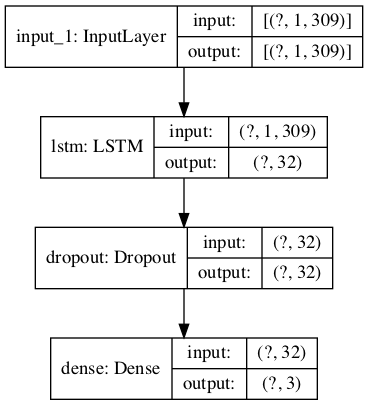

In [10]:
tf.keras.utils.plot_model(
    model,
    to_file="LSTM_Solar_Forecast_Model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [11]:
model.fit(train_gen, epochs=120,verbose=2)

Epoch 1/120
135/135 - 0s - loss: 1.3552 - acc: 0.3409
Epoch 2/120
135/135 - 0s - loss: 1.3323 - acc: 0.4137
Epoch 3/120
135/135 - 0s - loss: 1.3133 - acc: 0.4610
Epoch 4/120
135/135 - 0s - loss: 1.2969 - acc: 0.5070
Epoch 5/120
135/135 - 0s - loss: 1.2815 - acc: 0.5135
Epoch 6/120
135/135 - 0s - loss: 1.2651 - acc: 0.5301
Epoch 7/120
135/135 - 0s - loss: 1.2597 - acc: 0.5306
Epoch 8/120
135/135 - 0s - loss: 1.2392 - acc: 0.5450
Epoch 9/120
135/135 - 0s - loss: 1.2323 - acc: 0.5339
Epoch 10/120
135/135 - 0s - loss: 1.2238 - acc: 0.5394
Epoch 11/120
135/135 - 0s - loss: 1.2072 - acc: 0.5385
Epoch 12/120
135/135 - 0s - loss: 1.1936 - acc: 0.5408
Epoch 13/120
135/135 - 0s - loss: 1.1877 - acc: 0.5496
Epoch 14/120
135/135 - 0s - loss: 1.1729 - acc: 0.5566
Epoch 15/120
135/135 - 0s - loss: 1.1665 - acc: 0.5696
Epoch 16/120
135/135 - 0s - loss: 1.1569 - acc: 0.5649
Epoch 17/120
135/135 - 0s - loss: 1.1459 - acc: 0.5737
Epoch 18/120
135/135 - 0s - loss: 1.1336 - acc: 0.5886
Epoch 19/120
135/13

In [12]:
model.save("LSTM_Weather_Model.h5")

## Test Model

In [13]:
test_df = pd.read_csv(working_dir+"/test_weather.csv")
test_df.index = test_df['Unnamed: 0'].values
test_df.drop(['Unnamed: 0'],axis=1,inplace=True)

y_test = test_df["p_target"].values
y_test_hot = np.zeros((y_test.size, y_test.max()+1))
y_test_hot[np.arange(y_test.size),y_test] = 1

test_df.drop(['p_target'],axis=1,inplace=True)
X_test = test_df.values

test_gen = TimeseriesGenerator(X_test, y_test_hot,length=time_steps, batch_size=2)

In [14]:
yh = model.predict(test_gen)

target_names = ['low', 'mid', 'high']
print(classification_report(y_test[:yh.shape[0]], np.argmax(yh,axis=1), target_names=target_names))

              precision    recall  f1-score   support

         low       0.73      1.00      0.84        97
         mid       0.67      0.35      0.46        68
        high       0.81      0.77      0.79        84

    accuracy                           0.75       249
   macro avg       0.74      0.71      0.70       249
weighted avg       0.74      0.75      0.72       249

